In [10]:
from imutils import paths
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import timeit
from tqdm import tqdm

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses

import tensorflow_addons as tfa

from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.xception import decode_predictions

In [11]:
print("[INFO]: Trying to Read the images")
imagePaths = list(paths.list_images(r'archive\pkm_c_aug_new'))
imagePaths[:10]

[INFO]: Trying to Read the images


['archive\\pkm_c_aug_new\\Abra\\62_0_6524.png',
 'archive\\pkm_c_aug_new\\Abra\\62_0_6527.png',
 'archive\\pkm_c_aug_new\\Abra\\62_0_6568.png',
 'archive\\pkm_c_aug_new\\Abra\\62_0_6570.png',
 'archive\\pkm_c_aug_new\\Abra\\62_0_668.png',
 'archive\\pkm_c_aug_new\\Abra\\62_0_6683.png',
 'archive\\pkm_c_aug_new\\Abra\\62_0_6720.png',
 'archive\\pkm_c_aug_new\\Abra\\62_0_6728.png',
 'archive\\pkm_c_aug_new\\Abra\\62_0_680.png',
 'archive\\pkm_c_aug_new\\Abra\\62_0_6815.png']

In [12]:
len(imagePaths)
imagePaths[860].split(os.path.sep)[-2]

'Blastoise'

In [13]:
# Initialize data and labels
# 데이터 및 레이블 초기화/
data = []
labels = []
dirList= []

In [14]:
# Formatting data and labels
for imagePath in tqdm(imagePaths):
    # Extract the class label from file name and append to labels
    # 파일 이름에서 클래스 레이블을 추출하고 레이블에 추가함
    label = imagePath.split(os.path.sep)[-2]
    #if label=="2":
     #   labels.append("1")
    #else:
     #   labels.append(label)
    labels.append(label)
    # Load the image, swap color channels, and resize it to be a fixed 224x224 pixels while ignoring the aspect ratio
    # 이미지를 로드하고, 컬러 채널을 스왑하고, 가로 세로 비율을 무시하고 고정 224x224 픽셀로 크기를 조정함
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    # Append to data
    # 데이터에 추가
    data.append(image)

# Convert the data and labels to NumPy arrays while scaling the pixel intensities to the range [0,1]
# 픽셀 강도를 [0,1] 범위로 조정하면서 데이터와 레이블을 NumPy 배열로 변환
data = np.array(data) / 255.0
labels = np.array(labels)

100%|██████████| 15100/15100 [03:17<00:00, 76.65it/s]


In [15]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

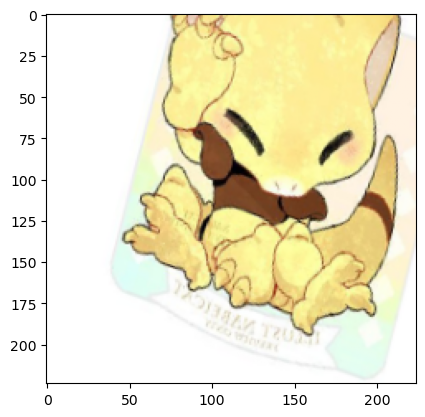

In [16]:
plt.imshow(data[19])

In [17]:
# Perform the one-hot encoding on the labels
# 레이블에 대해 원핫 인코딩 수행
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [18]:
# Initialize the training data augmentation
# 교육 데이터 억멘테이션 초기화
trainAug = ImageDataGenerator(zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2,
		shear_range=0.15,fill_mode="nearest", horizontal_flip=True)

In [19]:
# Partition the data into training and testing splits using 80% of the training data and the remaining 20% for testing
# 교육 데이터의 80%, 테스트에 20%를 사용하여 데이터를 교육 및 테스트 분할로 분할
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

MemoryError: Unable to allocate 3.39 GiB for an array with shape (3020, 224, 224, 3) and data type float64

In [20]:
# Load the network, ensuring the Head-FC layer sets are left off
# Head-FC 레이어 세트가 포함되지 않도록 네트워크를 로드한다
baseModel = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

83697664/83683744 [==============================] - 4s 0us/step


In [21]:
labels.shape

(15100, 151)

In [22]:

# Construct the head model that will be placed on the top of the base model
# 보디 모델의 맨 위에 배치할 헤드 모델 구성
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4,4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(151, activation="softmax")(headModel)

In [23]:
# Place the Head-FC model on top of the Base model - This become the actual model that we will train
# Head-FC 모델을 보디 모델 위에 배치한다. 이것이 우리가 교육할 실제 모델이 될 것이다.
model = Model(inputs=baseModel.input, outputs=headModel)

In [24]:
# Make sure that the basemodel layers will not be trained and only head model will be trained.
# 보디 모델 레이어가 훈련되지 않고 헤드 모델만 훈련되는지 확인한다.
for layer in baseModel.layers:
    layer.trainable = False

In [25]:
trainX.shape

NameError: name 'trainX' is not defined

In [26]:
# Set the hyper-parameters
# 하이퍼 파라미터 설정
# INIT_LR = 1e-3
INIT_LR = 0.0001
EPOCHS = 100
BS = 8

In [ ]:
# Compile the Model
# 모델 컴파일
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), optimizer=opt, metrics=["accuracy"])

In [ ]:
# Train the Network Model
# 모델 교육
print("[INFO] Model Training")
start = timeit.default_timer()
H = model.fit(
        trainAug.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
        class_weight=dict(enumerate(class_weights)),
        epochs=EPOCHS)

In [ ]:
stop = timeit.default_timer()
print('Total Training Time: ', stop - start) 

In [ ]:
# Make predictions on the testing set
# 테스트 세트에서 예측한다
print("Making Predictions on the Test Set")
predIdxs = model.predict(testX, batch_size=BS)
preds = predIdxs
predIdxs = np.argmax(predIdxs, axis=1)
print("Classification Report")
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

In [ ]:
# Compute Confusion Matrix and derrive raw, accuracy, sensitivity, specificity from it
# 혼란 매트릭스
cm= confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0,0] + cm[1,1] +cm[2,2]) / total

sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
# 혼란 매트릭스 보기
print("Confusion Matrix and its Derrivatives")
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [ ]:
acc = (cm[0,0] + cm[1,1] + cm[2,2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0,2])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1] + cm[1,2])
specificity2 = cm[2, 2] / (cm[2, 0] + cm[2, 1] + cm[2,2])
specificity = (specificity + specificity2) / 2
print(acc)
print(sensitivity)
print(specificity)

In [ ]:
# plot the training loss and accuracy
# 플롯 그래프
print("Final Plot Generated.")
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Allergic Rhinitis XceptNet-Aligned-all-e-3-0.5")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("[iter-3] [XCEPTN] plot,rotate-1e3")